In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import chi2_contingency,f_oneway
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,recall_score,precision_score,f1_score,roc_curve,roc_auc_score

In [2]:
insurance_df=pd.read_csv('insurance_claims.csv')
insurance_df.shape

(1000, 39)

In [3]:
insurance_df_copy=insurance_df.copy()
insurance_df_copy.shape

(1000, 39)

In [4]:
y=insurance_df['fraud_reported']
insurance_df.drop(columns='fraud_reported',inplace=True)

In [5]:
insurance_df.shape

(1000, 38)

In [6]:
#dropping all unnecessary columns from dataframe
cols_to_drop=[]
na_df=pd.DataFrame({'columns':insurance_df.columns,'null_count':insurance_df.isnull().sum(),
                    'na_per':insurance_df.isnull().sum()/insurance_df.shape[0]*100})
#no null values here in given dataframe
for col in insurance_df.columns:
    if len(insurance_df[col].value_counts())==1 or len(insurance_df[col].value_counts())==insurance_df.shape[0]:
        cols_to_drop.append(col)
cols_to_drop
insurance_df.drop(columns=cols_to_drop,inplace=True)

In [7]:
insurance_df.shape

(1000, 36)

In [8]:
insurance_df.dtypes

months_as_customer               int64
age                              int64
policy_bind_date                object
policy_state                    object
policy_csl                      object
policy_deductable                int64
policy_annual_premium          float64
umbrella_limit                   int64
insured_zip                      int64
insured_sex                     object
insured_education_level         object
insured_occupation              object
insured_hobbies                 object
insured_relationship            object
capital-gains                    int64
capital-loss                     int64
incident_date                   object
incident_type                   object
collision_type                  object
incident_severity               object
authorities_contacted           object
incident_state                  object
incident_city                   object
incident_hour_of_the_day         int64
number_of_vehicles_involved      int64
property_damage          

In [9]:
insurance_df['policy_bind_date']=pd.to_datetime(insurance_df['policy_bind_date'])
insurance_df['incident_date']=pd.to_datetime(insurance_df['incident_date'])
#insurance_df

In [10]:
#correlation check
#CHI-SQUARE test
correlated_columns=[]
for col in insurance_df.columns:
    if insurance_df[col].dtype=='object':
        contigency_table=pd.crosstab(insurance_df[col],y)
        res=chi2_contingency(contigency_table)
        if res[1]<0.05:
            correlated_columns.append(col)

#ANNOVA test
catogories_list=list(insurance_df_copy['fraud_reported'].value_counts().index)
con_col_aftrdropng=[col for col in insurance_df.columns if insurance_df[col].dtype=='int64' or insurance_df[col].dtype=='float64']
for col in con_col_aftrdropng:    
    result=f_oneway(*(insurance_df_copy[insurance_df_copy['fraud_reported']==category][col] for category in catogories_list))
    if result[1]<0.05:
        correlated_columns.append(col)

            
corr_df=insurance_df[correlated_columns]
#corr_df

In [11]:
#train-test-split
x_train,x_test,y_train,y_test=train_test_split(corr_df,y,test_size=0.2,random_state=53)

In [12]:
#filling missing values
for col in x_train.columns:
    if x_train[col].dtype=='int64' or x_train[col].dtype=='float64':
        x_train[col].fillna(x_train[col].mean(),inplace=True)
        x_test[col].fillna(x_train[col].mean(),inplace=True)
    if x_train[col].dtype=='object':
        x_train[col].fillna(x_train[col].mode()[0],inplace=True)
        x_test[col].fillna(x_train[col].mode()[0],inplace=True) 


In [13]:
#scaling the continuous variables
scaler=StandardScaler()
con_cols=[col for col in x_train.columns if x_train[col].dtype=='int64' or x_train[col].dtype=='float64']
for col in con_cols:
    x_train[col]=scaler.fit_transform(np.array(x_train[col]).reshape(-1,1))
    x_test[col]=scaler.transform(np.array(x_test[col]).reshape(-1,1))


In [14]:
#one-hot coding for categorical variables
oe_train=pd.get_dummies(x_train[[col for col in x_train.columns if x_train[col].dtype=='object']])
oe_test=pd.get_dummies(x_test[[col for col in x_test.columns if x_test[col].dtype=='object']])
oe_train_final,oe_test_final=oe_train.align(oe_test,join='inner',axis=1)

In [15]:
#getting final train and test inputs.
x_train_final=pd.concat([x_train[con_cols],oe_train_final],axis=1)
x_test_final=pd.concat([x_test[con_cols],oe_test_final],axis=1)

In [16]:
#Training the model
logreg=LogisticRegression()
logreg.fit(x_train_final,y_train)

LogisticRegression()

In [17]:
#getting predictions on test inputs
pred=logreg.predict(x_test_final)

In [18]:
#getting prediction probabilities
probabilities=logreg.predict_proba(x_test_final)
pos_prob=probabilities[::,1]
pos_prob

array([0.0390021 , 0.0553887 , 0.1497919 , 0.96503447, 0.04378014,
       0.04607468, 0.04398135, 0.12609814, 0.69346452, 0.50777819,
       0.60515612, 0.03264243, 0.07729386, 0.05043094, 0.05063939,
       0.81323108, 0.55967457, 0.0254206 , 0.5287984 , 0.07075854,
       0.06921462, 0.46271847, 0.08321288, 0.6543703 , 0.05630006,
       0.0423201 , 0.02455066, 0.55401241, 0.67336946, 0.07407609,
       0.6423786 , 0.04275429, 0.77006024, 0.88292036, 0.02742929,
       0.54511551, 0.04191807, 0.99010326, 0.26693361, 0.04033954,
       0.67335029, 0.3959488 , 0.56521736, 0.06195534, 0.98512732,
       0.06516549, 0.67002008, 0.5085618 , 0.56384578, 0.06079988,
       0.454262  , 0.02064005, 0.04643204, 0.06829659, 0.10506294,
       0.74921129, 0.43773144, 0.04339207, 0.03607766, 0.05615228,
       0.02668158, 0.05678628, 0.95296483, 0.04040339, 0.07578695,
       0.07523439, 0.08342953, 0.62843947, 0.08820725, 0.66887007,
       0.5030648 , 0.08022793, 0.69308134, 0.70123928, 0.09070

In [19]:
confusion_matrix(y_test,pred)

array([[125,  20],
       [ 16,  39]], dtype=int64)

In [20]:
precision_score(y_test,pred,pos_label='Y')

0.6610169491525424

In [21]:
recall_score(y_test,pred,pos_label='Y')

0.7090909090909091

In [22]:
f1_score(y_test,pred,pos_label='Y')

0.6842105263157895

In [23]:
fpr,tpr,thresholds=roc_curve(y_test,pos_prob,pos_label='Y') #false positive rate and true positive rate values to plot au_roc curve
fpr,tpr,thresholds

(array([0.        , 0.00689655, 0.00689655, 0.0137931 , 0.0137931 ,
        0.03448276, 0.03448276, 0.04137931, 0.04137931, 0.04827586,
        0.04827586, 0.05517241, 0.05517241, 0.06896552, 0.06896552,
        0.07586207, 0.07586207, 0.08275862, 0.08275862, 0.08965517,
        0.08965517, 0.09655172, 0.09655172, 0.10344828, 0.10344828,
        0.11724138, 0.11724138, 0.12413793, 0.12413793, 0.13103448,
        0.13103448, 0.13793103, 0.13793103, 0.14482759, 0.14482759,
        0.15172414, 0.15172414, 0.15862069, 0.15862069, 0.17241379,
        0.17241379, 0.24827586, 0.24827586, 0.35172414, 0.35172414,
        0.42068966, 0.42068966, 0.65517241, 0.65517241, 0.74482759,
        0.74482759, 1.        ]),
 array([0.        , 0.        , 0.01818182, 0.01818182, 0.03636364,
        0.03636364, 0.07272727, 0.07272727, 0.12727273, 0.12727273,
        0.16363636, 0.16363636, 0.2       , 0.2       , 0.25454545,
        0.25454545, 0.29090909, 0.29090909, 0.34545455, 0.34545455,
        0.3818

Text(0, 0.5, 'True positive rate')

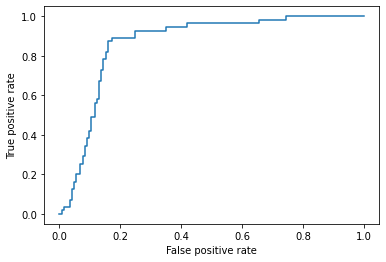

In [24]:
plt.plot(fpr,tpr) #auc_roc curve plot
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

In [25]:
roc_auc_score(y_test,pos_prob) #calculating area under curve

0.8630721003134796